In [ ]:
# %%

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))

import importlib
import preprocessing.pipeline
importlib.reload(preprocessing.pipeline)
from preprocessing.pipeline import get_preprocessor

In [ ]:
# %%

# === Import data ===
train = pd.read_csv("../data/train.csv")
# Remove specific outlier IDs with predicted SalePrice > 350K
outlier_ids_to_remove = [524, 1299, 1360]
train = train[~train["Id"].isin(outlier_ids_to_remove)].reset_index(drop=True)
X_test = pd.read_csv("../data/test.csv")

X_train = train.drop("SalePrice", axis=1)
y_train = train["SalePrice"]

In [ ]:
# %%

# === Build preprocessing + modeling pipeline ===
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
    greater_is_better=False
)

model_pipeline = Pipeline([
    ("preprocessor", get_preprocessor()),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

param_grid = {
    'model__regressor__alpha': [0.1, 1.0, 10.0, 100.0]
}

# === Apply preprocessing manually (after removing high SalePrice outliers) ===
preprocessor = get_preprocessor().named_steps['preprocessing']
X_test = X_test.copy()
X_train_clean = preprocessor.fit_transform(X_train)
X_test_clean = preprocessor.transform(X_test)
mask = X_train_clean.index
y_train_clean = y_train.loc[mask].reset_index(drop=True)
X_train_clean = X_train_clean.reset_index(drop=True)

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_clean, y_train_clean)
model_pipeline = grid_search.best_estimator_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [ ]:
# %%

# === Results from CV ===
print(f"Best hyperparameters: {grid_search.best_params_}")

Best hyperparameters: {'model__regressor__alpha': 10.0}


In [ ]:
# %%

# === Fit on full training data ===
model_pipeline.fit(X_train_clean, y_train_clean)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('drop_id',
                                                   ColumnDropper(columns_to_drop=['Id'])),
                                                  ('cat_na_fill',
                                                   CategoricalNaFiller(excluded_cols=['GarageYrBlt'])),
                                                  ('num_na_fill',
                                                   NumericalNaFiller(excluded_cols=['LotFrontage'])),
                                                  ('garage_bin',
                                                   GarageYrBltBinner()),
                                                  ('remove_outliers',
                                                   OutlierRemover()),
                                                  ('skewed_transform',
                                                   SkewedFeatureTransformer())])),
                                 ('transformer', OneHotEncoderScaler()),
                                 ('lotfrontage_fill', LotFrontageFiller())])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Ridge(alpha=10.0)))])

In [ ]:
# %%

# === Evaluate on training data ===
y_train_pred = model_pipeline.predict(X_train_clean)
train_rmse = np.sqrt(mean_squared_error(np.log1p(y_train_clean), np.log1p(y_train_pred)))
train_r2 = r2_score(y_train_clean, y_train_pred)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train R² Score: {train_r2:.4f}")

Train RMSE: 0.09
Train R² Score: 0.9534


In [ ]:
# %%

# === Compare training vs validation RMSE ===
val_preds_cv = cross_val_predict(model_pipeline, X_train_clean, y_train_clean, cv=KFold(n_splits=10, shuffle=True, random_state=42))
val_rmse = np.sqrt(mean_squared_error(np.log1p(y_train_clean), np.log1p(val_preds_cv)))
val_r2 = r2_score(y_train_clean, val_preds_cv)

print(f"Validation RMSE (CV): {val_rmse:.2f}")
print(f"Validation R² Score (CV): {val_r2:.4f}")

Validation RMSE (CV): 0.11
Validation R² Score (CV): 0.9378


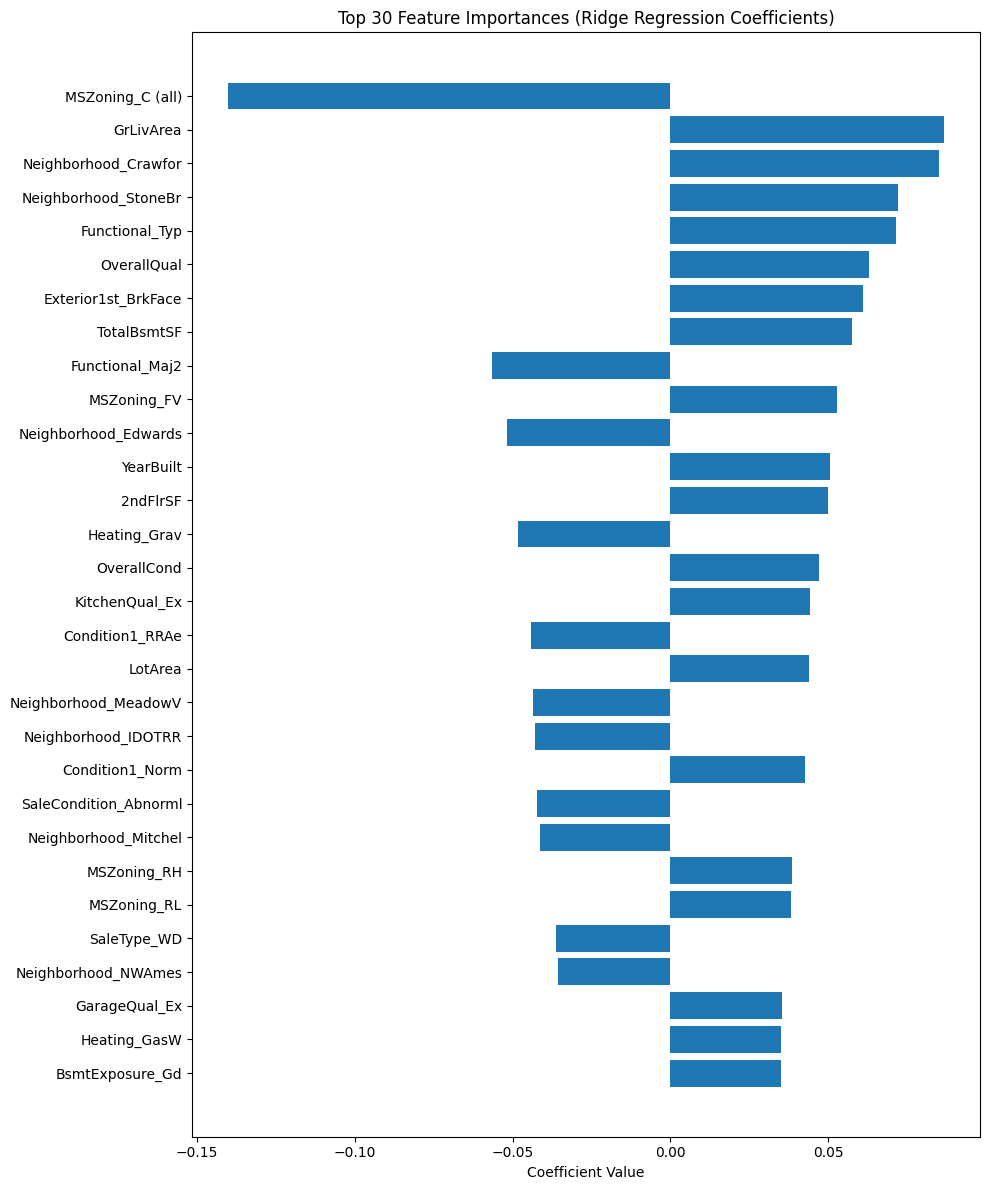

In [ ]:
# %%

# === Feature Importances (Ridge Coefficients) ===
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefs = model_pipeline.named_steps['model'].regressor_.coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(coef_df['Feature'][:30][::-1], coef_df['Coefficient'][:30][::-1])
plt.xlabel("Coefficient Value")
plt.title("Top 30 Feature Importances (Ridge Regression Coefficients)")
plt.tight_layout()
os.makedirs("../fig/rr", exist_ok=True)
plt.savefig("../fig/rr/feature_importances.png")
plt.show()

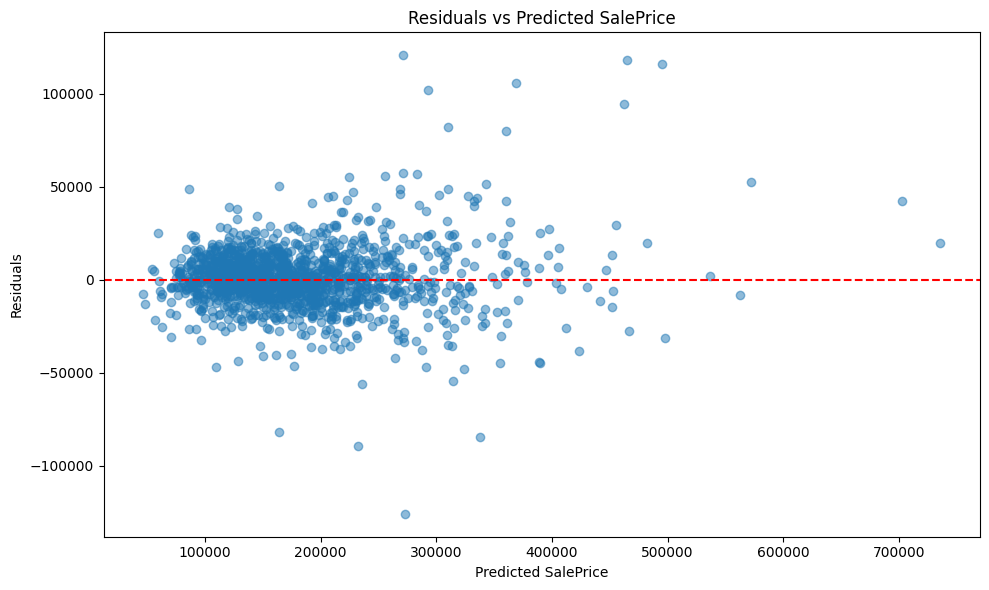

In [ ]:
# %%

# === Plot Residuals ===
residuals = y_train_clean - y_train_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted SalePrice")
plt.tight_layout()
plt.savefig("../fig/rr/residuals_vs_predicted.png")
plt.show()

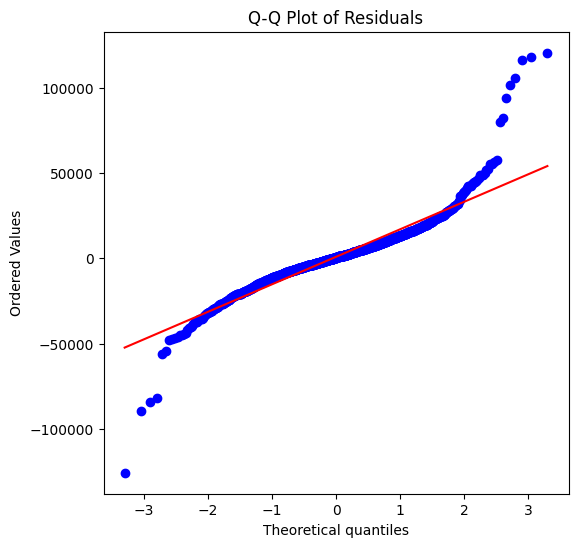

In [ ]:
# %%

# === QQ Plot of Residuals ===
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.savefig("../fig/rr/qq_plot_residuals.png")
plt.show()

In [ ]:
# %%

# === Predict on test data ===
y_test_pred = model_pipeline.predict(X_test_clean)

In [ ]:
# %%

# === Wrap in DataFrame ===
submission = pd.DataFrame({
    "Id": X_test["Id"],
    "SalePrice": y_test_pred
})

In [ ]:
# %%

# === Save in submission file ===
submission.to_csv("../data/submission_ridge.csv", index=False)

In [ ]:
# %%

# === Identify Outliers in Predicted SalePrice > 350K ===
outlier_threshold = 350000
outlier_mask = y_train_pred > outlier_threshold
outlier_ids = X_train.loc[outlier_mask, "Id"].values

print("Outlier IDs with predicted SalePrice > 350K:")
print(outlier_ids)

Outlier IDs with predicted SalePrice > 350K:
[  12   54   59  113  162  168  179  186  225  232  279  310  321  337
  350  390  441  474  478  482  497  516  528  592  643  645  662  665
  692  703  770  799  804  826  878  899  988  995 1047 1059 1143 1170
 1183 1229 1244 1269 1354 1374 1389 1438 1443]
